# ConversationTokenBufferMemory（不推荐使用）
`ConversationTokenBufferMemory` 是 LangChain 中一种基于 Token 数量控制 的对话记忆机制。如果字符数量超出指定数目，它会切掉这个对话的早期部分，以保留与最近的交流相对应的字符数量。

**特点：**
* Token 精准控制
* 原始对话保留

**原理：**

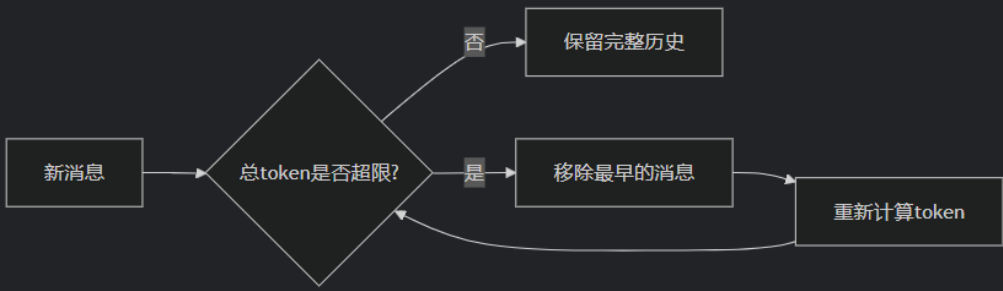